<a href="https://colab.research.google.com/github/smBello-tse/CIFAR10-classification/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import torch
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from time import time
root = '/kaggle/input'

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## **I. Data Pre-processing**



In [2]:
#Loading dataset
generator = torch.Generator().manual_seed(42)
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
val_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
val_dataset, _ = torch.utils.data.random_split(val_test_dataset, [0.5, 0.5], generator=generator)

100%|██████████| 170M/170M [00:11<00:00, 15.2MB/s]


Label is: 3
Image shape: torch.Size([3, 32, 32])


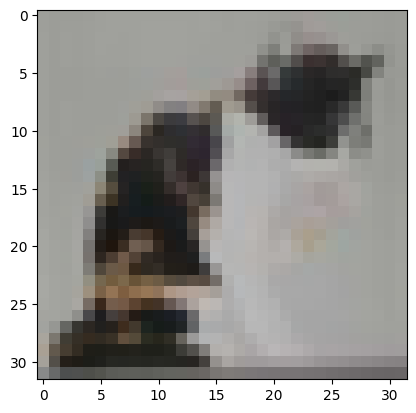

In [3]:
#Visualisation
image, target = train_dataset[785]
print(f"Label is: {target}")
print(f"Image shape: {image.shape}")
image = image.permute(1,2,0).numpy()
plt.imshow(image, cmap="gray")
plt.show()

In [4]:
def compute_mean_std_dataset(dataset):
  imgs = [item[0] for item in train_dataset] # item[0] and item[1] are image and its label
  imgs = torch.stack(imgs, dim=0).numpy()

# calculate mean over each channel (r,g,b)
  mean_r = imgs[:,0,:,:].mean()
  mean_g = imgs[:,1,:,:].mean()
  mean_b = imgs[:,2,:,:].mean()
  means = (mean_r,mean_g,mean_b)

# calculate std over each channel (r,g,b)
  std_r = imgs[:,0,:,:].std()
  std_g = imgs[:,1,:,:].std()
  std_b = imgs[:,2,:,:].std()
  stds = (std_r,std_g,std_b)
  return means, stds

means_train, stds_train = compute_mean_std_dataset(train_dataset)
means_val, stds_val = compute_mean_std_dataset(val_dataset)

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(means_train, stds_train), transforms.RandomRotation(degrees=(-40, 40)), transforms.RandomHorizontalFlip(), transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02)])
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(means_val, stds_val)])
val_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
val_dataset, _ = torch.utils.data.random_split(val_test_dataset, [0.5, 0.5], generator=generator)

In [6]:
#Creating dataloader
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=generator)

# **II. Model implementation**

In [7]:
class Conv_layer(torch.nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3, stride=None, padding=None):
    super().__init__()
    self.stride = 1 if stride is None else stride
    self.padding = 0 if padding is None else padding
    self.conv_layer = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, self.stride, self.padding),
                                          torch.nn.MaxPool2d(kernel_size=2),
                                          torch.nn.LeakyReLU())


  def forward(self, x):
    return self.conv_layer(x)

In [8]:
x, _ = train_dataset[785]
x = x.unsqueeze(0)
conv_layer = Conv_layer(3, 16, 5)
feature_map = conv_layer(x)
print(feature_map.shape)

torch.Size([1, 16, 14, 14])


In [9]:
class My_CNN(torch.nn.Module):

  def __init__(self, in_channels, out_channels, conv_kernels, fc_dims):
    super().__init__()
    self.in_channels = in_channels
    self.conv_kernels = conv_kernels
    self.fc_dims = fc_dims
    self.conv_layers = torch.nn.ModuleList([Conv_layer(cin, cout, kernel) for cin, cout, kernel in zip(in_channels, out_channels, conv_kernels)])
    self.fc_layers = torch.nn.ModuleList([torch.nn.Linear(dim_in, dim_out) for dim_in, dim_out in zip(fc_dims[:-1], fc_dims[1:])])
    #self.activation = torch.nn.LeakyReLU(1e-2)

  def forward(self, x):
    for conv_layer in self.conv_layers:
      x = conv_layer(x)
    #print(f"x shape is {x.shape}")
    x = x.view(x.size(0), -1)
    for fc_layer in self.fc_layers[:-1]:
      x = fc_layer(x)
      x = torch.nn.Dropout(0.2)(x)
      x = torch.nn.LeakyReLU(1e-2)(x)
    return self.fc_layers[-1](x)


# **III. Training and test**

In [10]:
def compute_Hf_Wf(conv_kernels, Hi, Wi):
    '''Computes the height and width of the output of the final convolutional layer. This function assumes a maxpool2D of kernel 2x2, as well as default stride(1), padding(0) and dilation(0) for both pooling and convolution.
    Parameters:
        * conv_kernels: a list or tuple of the kernels of the successive convolutional layers
        * Hi: Initial height
        * Wi: Initial width

    Outputs:
        * Hf: final height
        * Wf: final width
    '''

    Hf, Wf = Hi, Wi
    for k in conv_kernels:
      Hf = (Hf - (k - 1)) // 2
      Wf = (Wf - (k - 1)) // 2
    return Hf, Wf


conv_kernels, Hi, Wi = (5,3,3), 32, 32
Hf, Wf = compute_Hf_Wf(conv_kernels, Hi, Wi)
print(Hf, Wf)

2 2


In [11]:
image = train_dataset[785][0]
C, H, W = image.shape
nb_classes = 10
in_channels = (C, 64, 128)
out_channels = (64, 128, 256)
conv_kernels = (5, 3, 3)
Hf, Wf = compute_Hf_Wf(conv_kernels, H, W)
fc_dims = (out_channels[-1]*Hf*Wf, 512, 256, 128, nb_classes)
model = My_CNN(in_channels, out_channels, conv_kernels, fc_dims)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

My_CNN(
  (conv_layers): ModuleList(
    (0): Conv_layer(
      (conv_layer): Sequential(
        (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (1): Conv_layer(
      (conv_layer): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (2): Conv_layer(
      (conv_layer): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_

In [12]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")
print(f"Device is {device}")

Number of parameters: 1064202
Device is cuda


In [13]:
if device=="cuda": model = torch.compile(model)

In [14]:
optimizer = None #Just so that I can resume training

In [15]:
#Training and validation
nb_epochs = 150
if optimizer is None: optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
else: print(optimizer)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
losses_train, losses_val = [], []
best_loss = 1e5
lr_decay = 0.99
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)
torch.set_float32_matmul_precision('high')

model.train()

for epoch in range(nb_epochs):
  start = time()
  print(f"Epoch: {epoch}")
  #print("Now training...")
  loss_train, loss_val = 0, 0
  for idx, (batch, target) in tqdm(enumerate(train_loader)):
    batch, target = batch.to(device), target.to(device)
    optimizer.zero_grad()
    #with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
    preds = model(batch)
    #print(preds.shape, preds.dtype)
    #print(target.shape, target.dtype)
    loss = criterion(preds, target)
    loss.backward()
    loss_train += loss.item()
    optimizer.step()
  loss_train /= len(train_loader)
  losses_train.append(loss_train)
  scheduler.step()


  #print("Now validation...")
  with torch.no_grad():
    for idx, (batch, target) in tqdm(enumerate(val_loader)):
      batch, target = batch.to(device), target.to(device)
      preds = model(batch)
      #print(preds.shape, preds.dtype)
      #print(target.shape, target.dtype)
      loss = criterion(preds, target)
      loss_val += loss.item()
    loss_val /= len(val_loader)
    if loss_val < best_loss:
      best_loss = loss_val
      best_model, best_epoch = model, epoch
    losses_val.append(loss_val)

  print(f"Loss_train: {loss_train:.4f} and loss_val: {loss_val:.4f}")
end = time()


Epoch: 0


391it [01:36,  4.05it/s]
40it [00:01, 32.48it/s]


Loss_train: 1.9710 and loss_val: 5.2238
Epoch: 1


391it [01:35,  4.08it/s]
40it [00:01, 34.45it/s]


Loss_train: 1.7436 and loss_val: 5.6518
Epoch: 2


391it [01:36,  4.04it/s]
40it [00:01, 34.69it/s]


Loss_train: 1.6383 and loss_val: 3.3409
Epoch: 3


391it [01:36,  4.03it/s]
40it [00:01, 34.65it/s]


Loss_train: 1.5696 and loss_val: 2.5352
Epoch: 4


391it [01:32,  4.21it/s]
40it [00:01, 36.25it/s]


Loss_train: 1.5166 and loss_val: 3.0796
Epoch: 5


391it [01:32,  4.23it/s]
40it [00:01, 35.63it/s]


Loss_train: 1.4699 and loss_val: 3.7400
Epoch: 6


391it [01:32,  4.22it/s]
40it [00:01, 36.39it/s]


Loss_train: 1.4370 and loss_val: 2.7611
Epoch: 7


391it [01:33,  4.18it/s]
40it [00:01, 36.29it/s]


Loss_train: 1.4071 and loss_val: 2.5915
Epoch: 8


391it [01:33,  4.19it/s]
40it [00:01, 36.43it/s]


Loss_train: 1.3881 and loss_val: 3.1315
Epoch: 9


391it [01:36,  4.06it/s]
40it [00:01, 35.05it/s]


Loss_train: 1.3582 and loss_val: 3.2074
Epoch: 10


391it [01:33,  4.17it/s]
40it [00:01, 35.48it/s]


Loss_train: 1.3326 and loss_val: 2.9704
Epoch: 11


391it [01:31,  4.26it/s]
40it [00:01, 36.52it/s]


Loss_train: 1.3239 and loss_val: 2.7425
Epoch: 12


391it [01:31,  4.29it/s]
40it [00:01, 35.13it/s]


Loss_train: 1.3032 and loss_val: 3.3392
Epoch: 13


391it [01:34,  4.15it/s]
40it [00:01, 36.63it/s]


Loss_train: 1.2881 and loss_val: 3.7792
Epoch: 14


391it [01:31,  4.25it/s]
40it [00:01, 36.28it/s]


Loss_train: 1.2722 and loss_val: 3.5222
Epoch: 15


391it [01:31,  4.28it/s]
40it [00:01, 36.87it/s]


Loss_train: 1.2607 and loss_val: 3.3585
Epoch: 16


391it [01:30,  4.30it/s]
40it [00:01, 36.48it/s]


Loss_train: 1.2521 and loss_val: 3.8267
Epoch: 17


391it [01:32,  4.21it/s]
40it [00:01, 36.76it/s]


Loss_train: 1.2389 and loss_val: 3.4124
Epoch: 18


391it [01:32,  4.21it/s]
40it [00:01, 36.90it/s]


Loss_train: 1.2291 and loss_val: 3.6377
Epoch: 19


391it [01:31,  4.27it/s]
40it [00:01, 36.91it/s]


Loss_train: 1.2189 and loss_val: 4.1423
Epoch: 20


391it [01:32,  4.21it/s]
40it [00:01, 36.99it/s]


Loss_train: 1.2043 and loss_val: 3.3326
Epoch: 21


391it [01:31,  4.25it/s]
40it [00:01, 36.71it/s]


Loss_train: 1.1992 and loss_val: 3.5827
Epoch: 22


391it [01:32,  4.24it/s]
40it [00:01, 37.02it/s]


Loss_train: 1.1827 and loss_val: 4.5579
Epoch: 23


391it [01:31,  4.25it/s]
40it [00:01, 37.17it/s]


Loss_train: 1.1802 and loss_val: 3.9890
Epoch: 24


391it [01:33,  4.20it/s]
40it [00:01, 36.23it/s]


Loss_train: 1.1656 and loss_val: 3.9356
Epoch: 25


391it [01:32,  4.24it/s]
40it [00:01, 35.96it/s]


Loss_train: 1.1695 and loss_val: 4.5451
Epoch: 26


391it [01:32,  4.22it/s]
40it [00:01, 35.79it/s]


Loss_train: 1.1575 and loss_val: 3.8099
Epoch: 27


391it [01:32,  4.23it/s]
40it [00:01, 37.06it/s]


Loss_train: 1.1471 and loss_val: 4.2654
Epoch: 28


391it [01:30,  4.34it/s]
40it [00:01, 36.92it/s]


Loss_train: 1.1402 and loss_val: 4.2173
Epoch: 29


391it [01:30,  4.32it/s]
40it [00:01, 37.05it/s]


Loss_train: 1.1307 and loss_val: 4.4591
Epoch: 30


391it [01:30,  4.32it/s]
40it [00:01, 36.97it/s]


Loss_train: 1.1261 and loss_val: 3.8914
Epoch: 31


391it [01:30,  4.32it/s]
40it [00:01, 37.13it/s]


Loss_train: 1.1222 and loss_val: 4.3105
Epoch: 32


391it [01:31,  4.29it/s]
40it [00:01, 32.47it/s]


Loss_train: 1.1192 and loss_val: 4.4660
Epoch: 33


391it [01:35,  4.09it/s]
40it [00:01, 35.91it/s]


Loss_train: 1.1062 and loss_val: 4.5158
Epoch: 34


391it [01:31,  4.29it/s]
40it [00:01, 36.37it/s]


Loss_train: 1.1061 and loss_val: 4.5794
Epoch: 35


391it [01:31,  4.27it/s]
40it [00:01, 37.14it/s]


Loss_train: 1.0995 and loss_val: 5.1306
Epoch: 36


391it [01:30,  4.31it/s]
40it [00:01, 36.34it/s]


Loss_train: 1.0912 and loss_val: 5.1327
Epoch: 37


391it [01:31,  4.29it/s]
40it [00:01, 37.00it/s]


Loss_train: 1.0836 and loss_val: 5.0816
Epoch: 38


391it [01:32,  4.24it/s]
40it [00:01, 36.06it/s]


Loss_train: 1.0817 and loss_val: 4.4176
Epoch: 39


391it [01:31,  4.28it/s]
40it [00:01, 36.52it/s]


Loss_train: 1.0703 and loss_val: 4.2677
Epoch: 40


391it [01:31,  4.27it/s]
40it [00:01, 37.22it/s]


Loss_train: 1.0737 and loss_val: 4.3730
Epoch: 41


391it [01:31,  4.27it/s]
40it [00:01, 36.80it/s]


Loss_train: 1.0634 and loss_val: 4.6578
Epoch: 42


391it [01:31,  4.27it/s]
40it [00:01, 36.41it/s]


Loss_train: 1.0627 and loss_val: 4.3119
Epoch: 43


391it [01:32,  4.24it/s]
40it [00:01, 37.06it/s]


Loss_train: 1.0552 and loss_val: 5.1274
Epoch: 44


391it [01:30,  4.31it/s]
40it [00:01, 36.81it/s]


Loss_train: 1.0484 and loss_val: 4.9424
Epoch: 45


391it [01:30,  4.31it/s]
40it [00:01, 36.16it/s]


Loss_train: 1.0457 and loss_val: 4.9452
Epoch: 46


391it [01:30,  4.32it/s]
40it [00:01, 37.02it/s]


Loss_train: 1.0362 and loss_val: 5.0650
Epoch: 47


391it [01:31,  4.29it/s]
40it [00:01, 36.17it/s]


Loss_train: 1.0387 and loss_val: 4.6679
Epoch: 48


391it [01:30,  4.31it/s]
40it [00:01, 37.35it/s]


Loss_train: 1.0279 and loss_val: 4.6955
Epoch: 49


391it [01:31,  4.27it/s]
40it [00:01, 37.05it/s]


Loss_train: 1.0241 and loss_val: 5.1209
Epoch: 50


391it [01:30,  4.32it/s]
40it [00:01, 37.34it/s]


Loss_train: 1.0242 and loss_val: 4.3211
Epoch: 51


391it [01:31,  4.27it/s]
40it [00:01, 36.92it/s]


Loss_train: 1.0178 and loss_val: 4.1806
Epoch: 52


391it [01:31,  4.28it/s]
40it [00:01, 37.18it/s]


Loss_train: 1.0107 and loss_val: 4.4574
Epoch: 53


391it [01:31,  4.26it/s]
40it [00:01, 37.21it/s]


Loss_train: 1.0075 and loss_val: 4.8562
Epoch: 54


391it [01:30,  4.30it/s]
40it [00:01, 37.20it/s]


Loss_train: 1.0018 and loss_val: 4.6047
Epoch: 55


391it [01:31,  4.29it/s]
40it [00:01, 36.92it/s]


Loss_train: 1.0045 and loss_val: 5.1067
Epoch: 56


391it [01:31,  4.29it/s]
40it [00:01, 37.57it/s]


Loss_train: 0.9949 and loss_val: 4.4524
Epoch: 57


391it [01:31,  4.29it/s]
40it [00:01, 37.15it/s]


Loss_train: 0.9891 and loss_val: 4.0763
Epoch: 58


391it [01:30,  4.34it/s]
40it [00:01, 36.30it/s]


Loss_train: 0.9920 and loss_val: 4.3272
Epoch: 59


391it [01:33,  4.19it/s]
40it [00:01, 35.61it/s]


Loss_train: 0.9836 and loss_val: 4.7166
Epoch: 60


391it [01:33,  4.20it/s]
40it [00:01, 36.48it/s]


Loss_train: 0.9798 and loss_val: 4.6419
Epoch: 61


391it [01:33,  4.19it/s]
40it [00:01, 37.13it/s]


Loss_train: 0.9740 and loss_val: 5.1730
Epoch: 62


391it [01:31,  4.26it/s]
40it [00:01, 35.46it/s]


Loss_train: 0.9758 and loss_val: 4.7519
Epoch: 63


391it [01:33,  4.17it/s]
40it [00:01, 36.39it/s]


Loss_train: 0.9649 and loss_val: 5.0470
Epoch: 64


391it [01:33,  4.18it/s]
40it [00:01, 35.39it/s]


Loss_train: 0.9677 and loss_val: 5.1800
Epoch: 65


391it [01:32,  4.23it/s]
40it [00:01, 36.60it/s]


Loss_train: 0.9609 and loss_val: 5.2555
Epoch: 66


391it [01:31,  4.28it/s]
40it [00:01, 37.42it/s]


Loss_train: 0.9575 and loss_val: 5.3884
Epoch: 67


391it [01:31,  4.27it/s]
40it [00:01, 36.55it/s]


Loss_train: 0.9519 and loss_val: 4.7341
Epoch: 68


391it [01:30,  4.33it/s]
40it [00:01, 36.16it/s]


Loss_train: 0.9511 and loss_val: 4.8398
Epoch: 69


391it [01:31,  4.27it/s]
40it [00:01, 37.22it/s]


Loss_train: 0.9462 and loss_val: 4.9983
Epoch: 70


391it [01:32,  4.23it/s]
40it [00:01, 36.78it/s]


Loss_train: 0.9467 and loss_val: 4.7064
Epoch: 71


391it [01:32,  4.21it/s]
40it [00:01, 36.20it/s]


Loss_train: 0.9408 and loss_val: 5.4217
Epoch: 72


391it [01:31,  4.29it/s]
40it [00:01, 36.77it/s]


Loss_train: 0.9400 and loss_val: 5.3497
Epoch: 73


391it [01:31,  4.28it/s]
40it [00:01, 37.14it/s]


Loss_train: 0.9355 and loss_val: 5.1675
Epoch: 74


391it [01:33,  4.20it/s]
40it [00:01, 37.37it/s]


Loss_train: 0.9359 and loss_val: 5.4095
Epoch: 75


391it [01:33,  4.20it/s]
40it [00:01, 37.09it/s]


Loss_train: 0.9309 and loss_val: 5.1524
Epoch: 76


391it [01:32,  4.23it/s]
40it [00:01, 36.98it/s]


Loss_train: 0.9277 and loss_val: 5.4124
Epoch: 77


391it [01:34,  4.16it/s]
40it [00:01, 36.87it/s]


Loss_train: 0.9246 and loss_val: 5.4981
Epoch: 78


391it [01:32,  4.21it/s]
40it [00:01, 36.70it/s]


Loss_train: 0.9237 and loss_val: 5.6417
Epoch: 79


391it [01:31,  4.25it/s]
40it [00:01, 36.89it/s]


Loss_train: 0.9210 and loss_val: 5.0048
Epoch: 80


391it [01:34,  4.16it/s]
40it [00:01, 34.96it/s]


Loss_train: 0.9165 and loss_val: 5.8442
Epoch: 81


391it [01:34,  4.15it/s]
40it [00:01, 36.66it/s]


Loss_train: 0.9135 and loss_val: 5.3892
Epoch: 82


391it [01:33,  4.20it/s]
40it [00:01, 36.82it/s]


Loss_train: 0.9140 and loss_val: 5.9624
Epoch: 83


391it [01:34,  4.15it/s]
40it [00:01, 37.28it/s]


Loss_train: 0.9079 and loss_val: 5.6990
Epoch: 84


391it [01:33,  4.20it/s]
40it [00:01, 37.04it/s]


Loss_train: 0.9042 and loss_val: 4.5920
Epoch: 85


391it [01:31,  4.28it/s]
40it [00:01, 36.67it/s]


Loss_train: 0.9047 and loss_val: 4.9343
Epoch: 86


391it [01:32,  4.24it/s]
40it [00:01, 36.75it/s]


Loss_train: 0.9004 and loss_val: 5.0381
Epoch: 87


391it [01:31,  4.26it/s]
40it [00:01, 37.13it/s]


Loss_train: 0.8968 and loss_val: 4.9752
Epoch: 88


391it [01:31,  4.26it/s]
40it [00:01, 36.25it/s]


Loss_train: 0.8974 and loss_val: 4.9500
Epoch: 89


391it [01:32,  4.21it/s]
40it [00:01, 36.91it/s]


Loss_train: 0.8964 and loss_val: 5.3016
Epoch: 90


391it [01:33,  4.18it/s]
40it [00:01, 37.00it/s]


Loss_train: 0.8906 and loss_val: 4.8367
Epoch: 91


391it [01:34,  4.13it/s]
40it [00:01, 36.33it/s]


Loss_train: 0.8858 and loss_val: 4.7671
Epoch: 92


391it [01:32,  4.22it/s]
40it [00:01, 36.74it/s]


Loss_train: 0.8855 and loss_val: 4.9903
Epoch: 93


391it [01:33,  4.16it/s]
40it [00:01, 36.89it/s]


Loss_train: 0.8784 and loss_val: 5.0420
Epoch: 94


391it [01:31,  4.29it/s]
40it [00:01, 36.71it/s]


Loss_train: 0.8774 and loss_val: 4.8584
Epoch: 95


391it [01:31,  4.26it/s]
40it [00:01, 36.56it/s]


Loss_train: 0.8808 and loss_val: 4.5396
Epoch: 96


391it [01:32,  4.23it/s]
40it [00:01, 36.80it/s]


Loss_train: 0.8733 and loss_val: 4.8962
Epoch: 97


391it [01:32,  4.21it/s]
40it [00:01, 35.73it/s]


Loss_train: 0.8752 and loss_val: 5.1203
Epoch: 98


391it [01:34,  4.14it/s]
40it [00:01, 37.13it/s]


Loss_train: 0.8720 and loss_val: 5.0999
Epoch: 99


391it [01:33,  4.18it/s]
40it [00:01, 35.32it/s]


Loss_train: 0.8678 and loss_val: 4.7467
Epoch: 100


391it [01:33,  4.19it/s]
40it [00:01, 36.81it/s]


Loss_train: 0.8648 and loss_val: 4.7934
Epoch: 101


391it [01:32,  4.25it/s]
40it [00:01, 36.60it/s]


Loss_train: 0.8679 and loss_val: 4.6174
Epoch: 102


391it [01:31,  4.28it/s]
40it [00:01, 33.75it/s]


Loss_train: 0.8579 and loss_val: 4.7575
Epoch: 103


391it [01:33,  4.16it/s]
40it [00:01, 36.04it/s]


Loss_train: 0.8544 and loss_val: 4.6873
Epoch: 104


391it [01:35,  4.09it/s]
40it [00:01, 35.69it/s]


Loss_train: 0.8604 and loss_val: 4.8524
Epoch: 105


391it [01:35,  4.11it/s]
40it [00:01, 37.06it/s]


Loss_train: 0.8545 and loss_val: 4.9876
Epoch: 106


391it [01:32,  4.24it/s]
40it [00:01, 37.03it/s]


Loss_train: 0.8519 and loss_val: 5.0910
Epoch: 107


391it [01:30,  4.30it/s]
40it [00:01, 36.53it/s]


Loss_train: 0.8538 and loss_val: 5.3104
Epoch: 108


391it [01:34,  4.13it/s]
40it [00:01, 37.16it/s]


Loss_train: 0.8522 and loss_val: 5.2852
Epoch: 109


391it [01:33,  4.18it/s]
40it [00:01, 37.18it/s]


Loss_train: 0.8480 and loss_val: 4.4369
Epoch: 110


391it [01:32,  4.21it/s]
40it [00:01, 35.64it/s]


Loss_train: 0.8437 and loss_val: 4.5606
Epoch: 111


391it [01:33,  4.17it/s]
40it [00:01, 37.23it/s]


Loss_train: 0.8446 and loss_val: 5.0534
Epoch: 112


391it [01:32,  4.23it/s]
40it [00:01, 37.09it/s]


Loss_train: 0.8401 and loss_val: 4.8018
Epoch: 113


391it [01:34,  4.12it/s]
40it [00:01, 35.19it/s]


Loss_train: 0.8406 and loss_val: 4.8140
Epoch: 114


391it [01:33,  4.16it/s]
40it [00:01, 36.96it/s]


Loss_train: 0.8378 and loss_val: 4.6433
Epoch: 115


391it [01:34,  4.13it/s]
40it [00:01, 35.61it/s]


Loss_train: 0.8380 and loss_val: 4.6222
Epoch: 116


391it [01:34,  4.14it/s]
40it [00:01, 36.98it/s]


Loss_train: 0.8351 and loss_val: 4.4177
Epoch: 117


391it [01:32,  4.22it/s]
40it [00:01, 35.29it/s]


Loss_train: 0.8352 and loss_val: 4.7278
Epoch: 118


391it [01:32,  4.22it/s]
40it [00:01, 36.94it/s]


Loss_train: 0.8335 and loss_val: 4.6196
Epoch: 119


391it [01:32,  4.21it/s]
40it [00:01, 35.40it/s]


Loss_train: 0.8284 and loss_val: 4.7164
Epoch: 120


391it [01:33,  4.18it/s]
40it [00:01, 36.92it/s]


Loss_train: 0.8271 and loss_val: 4.8035
Epoch: 121


391it [01:32,  4.25it/s]
40it [00:01, 37.42it/s]


Loss_train: 0.8221 and loss_val: 5.3521
Epoch: 122


391it [01:32,  4.25it/s]
40it [00:01, 37.19it/s]


Loss_train: 0.8246 and loss_val: 4.6632
Epoch: 123


391it [01:31,  4.26it/s]
40it [00:01, 35.36it/s]


Loss_train: 0.8227 and loss_val: 4.9906
Epoch: 124


391it [01:33,  4.20it/s]
40it [00:01, 34.95it/s]


Loss_train: 0.8210 and loss_val: 4.6179
Epoch: 125


391it [01:36,  4.07it/s]
40it [00:01, 36.26it/s]


Loss_train: 0.8201 and loss_val: 4.8358
Epoch: 126


391it [01:35,  4.09it/s]
40it [00:01, 36.94it/s]


Loss_train: 0.8190 and loss_val: 4.7352
Epoch: 127


391it [01:31,  4.25it/s]
40it [00:01, 36.75it/s]


Loss_train: 0.8125 and loss_val: 4.7496
Epoch: 128


391it [01:32,  4.21it/s]
40it [00:01, 36.58it/s]


Loss_train: 0.8124 and loss_val: 4.9518
Epoch: 129


391it [01:33,  4.16it/s]
40it [00:01, 36.19it/s]


Loss_train: 0.8125 and loss_val: 4.8071
Epoch: 130


391it [01:33,  4.19it/s]
40it [00:01, 37.46it/s]


Loss_train: 0.8126 and loss_val: 4.6310
Epoch: 131


391it [01:32,  4.24it/s]
40it [00:01, 37.14it/s]


Loss_train: 0.8088 and loss_val: 4.6062
Epoch: 132


391it [01:33,  4.16it/s]
40it [00:01, 37.39it/s]


Loss_train: 0.8065 and loss_val: 4.5373
Epoch: 133


391it [01:32,  4.21it/s]
40it [00:01, 37.19it/s]


Loss_train: 0.8028 and loss_val: 4.6769
Epoch: 134


391it [01:32,  4.22it/s]
40it [00:01, 36.17it/s]


Loss_train: 0.8092 and loss_val: 4.2313
Epoch: 135


391it [01:35,  4.11it/s]
40it [00:01, 36.43it/s]


Loss_train: 0.8035 and loss_val: 4.5244
Epoch: 136


391it [01:35,  4.07it/s]
40it [00:01, 37.00it/s]


Loss_train: 0.8019 and loss_val: 4.5950
Epoch: 137


391it [01:37,  4.02it/s]
40it [00:01, 33.39it/s]


Loss_train: 0.7996 and loss_val: 4.7996
Epoch: 138


391it [01:35,  4.09it/s]
40it [00:01, 36.96it/s]


Loss_train: 0.8010 and loss_val: 4.4402
Epoch: 139


391it [01:36,  4.05it/s]
40it [00:01, 35.46it/s]


Loss_train: 0.7993 and loss_val: 4.4765
Epoch: 140


391it [01:33,  4.16it/s]
40it [00:01, 36.21it/s]


Loss_train: 0.7983 and loss_val: 4.3986
Epoch: 141


391it [01:34,  4.12it/s]
40it [00:01, 35.99it/s]


Loss_train: 0.7946 and loss_val: 4.6001
Epoch: 142


391it [01:33,  4.18it/s]
40it [00:01, 34.77it/s]


Loss_train: 0.7933 and loss_val: 4.4613
Epoch: 143


391it [01:34,  4.15it/s]
40it [00:01, 36.12it/s]


Loss_train: 0.7941 and loss_val: 4.3407
Epoch: 144


391it [01:36,  4.05it/s]
40it [00:01, 35.71it/s]


Loss_train: 0.7886 and loss_val: 4.3274
Epoch: 145


391it [01:35,  4.08it/s]
40it [00:01, 35.22it/s]


Loss_train: 0.7956 and loss_val: 4.3414
Epoch: 146


391it [01:34,  4.13it/s]
40it [00:01, 37.69it/s]


Loss_train: 0.7873 and loss_val: 4.4883
Epoch: 147


391it [01:35,  4.09it/s]
40it [00:01, 37.21it/s]


Loss_train: 0.7812 and loss_val: 4.4547
Epoch: 148


391it [01:32,  4.25it/s]
40it [00:01, 37.28it/s]


Loss_train: 0.7865 and loss_val: 4.8237
Epoch: 149


391it [01:33,  4.18it/s]
40it [00:01, 36.61it/s]

Loss_train: 0.7827 and loss_val: 4.4302


Time elapsed: 94.62976598739624
Seconds per epoch: 0.6308651065826416
Best epoch: 3
Best loss: 2.5352


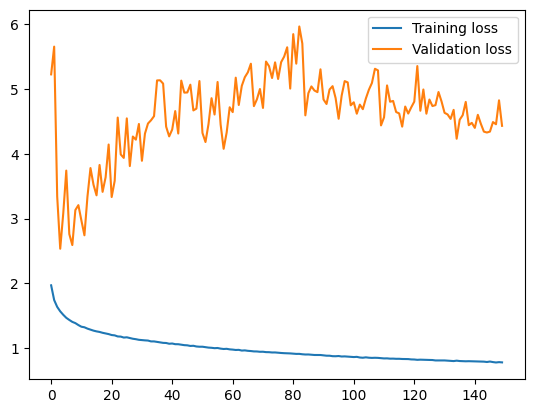

In [16]:
time_elapsed = end- start
print(f"Time elapsed: {time_elapsed}")
print(f"Seconds per epoch: {time_elapsed / nb_epochs}")
print(f"Best epoch: {best_epoch}")
print(f"Best loss: {best_loss:.4f}")

epochs = range(nb_epochs)

plt.plot(epochs, losses_train, label="Training loss")
plt.plot(epochs, losses_val, label="Validation loss")
plt.legend()
plt.show()

In [17]:
#Test on val data
best_model.eval()
print("Now testing...")
loss_test = 0
test_batch = next(iter(val_loader))
all_preds = []
all_targets = []
with torch.no_grad():
  for idx, (batch, target) in tqdm(enumerate(val_loader)):
      batch, target = batch.to(device), target.to(device)
      preds = best_model(batch)
      loss = criterion(preds, target)
      loss_test += loss.item()
      all_preds.append(torch.argmax(preds, dim=-1).cpu().numpy())
      all_targets.append(target.cpu().numpy())
  all_preds = np.concatenate(all_preds)
  all_targets = np.concatenate(all_targets)
  loss_test /= len(val_loader)

  print(f"Loss_test: {loss_test:.4f}")

Now testing...


40it [00:01, 36.25it/s]

Loss_test: 4.3855


<Axes: >

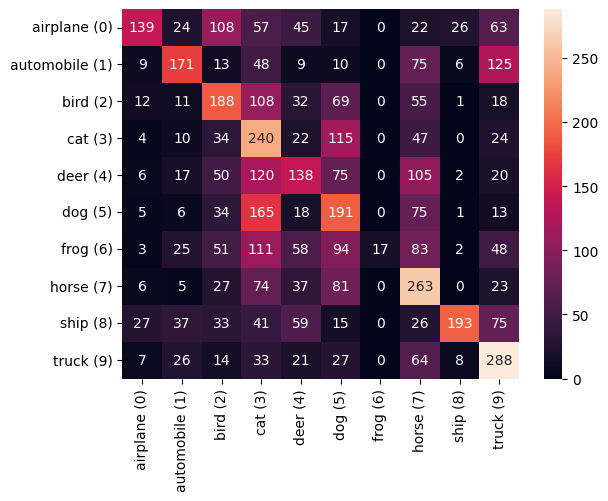

In [18]:
labels = ["airplane (0)", "automobile (1)", "bird (2)", "cat (3)", "deer (4)", "dog (5)", "frog (6)", "horse (7)", "ship (8)", "truck (9)"]
#
cm = confusion_matrix(all_targets, all_preds, labels=range(10))
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(cm_df, annot=True, fmt="d")

In [19]:
print(f"Accuracy score is: {accuracy_score(all_targets, all_preds)}")

Accuracy score is: 0.3656


In [20]:
def accuracy_multi_class(y_true, y_pred, cm):
  '''
  y_true: true labels
  y_pred: predicted labels
  cm: confusion matrix

  return list of accuracies for each classes
  '''
  accuracies = np.zeros((cm.shape[0],))
  for i in range(cm.shape[0]):
    accuracies[i] = cm[i,i] / np.sum(cm[i,:])
  return accuracies

accuracies = accuracy_multi_class(all_targets, all_preds, cm)
accuracies_df = pd.DataFrame(accuracies, index=labels, columns=["Accuracy"])
accuracies_df = accuracies_df.sort_values(by="Accuracy", ascending=False)
print(accuracies_df)
print("Mean of accuracies: ", accuracies_df["Accuracy"].mean())

                Accuracy
truck (9)       0.590164
horse (7)       0.509690
cat (3)         0.483871
ship (8)        0.381423
bird (2)        0.380567
dog (5)         0.375984
automobile (1)  0.366953
airplane (0)    0.277445
deer (4)        0.258912
frog (6)        0.034553
Mean of accuracies:  0.3659561368033803


In [21]:
checkpoint = {
    "model": best_model.state_dict(),
    "optimizer": optimizer.state_dict(),
    "best_loss": best_loss,
    "epoch": best_epoch
}

# Save to a file in the working directory
torch.save(checkpoint, "/kaggle/working/checkpoint_LeakyReLU_dropout.pth")